In [1]:
import sys

sys.path.insert(0, '..')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.fft

from pathlib import Path
import numpy as np
from torch.utils.data import DataLoader
from core.dataset_multimodal import collate_fn, ASASSNVarStarDataset
from functools import partial
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import random
import numpy as np
import json
import os

/home/mrizhko/anaconda3/envs/period/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Opening v data files... Found 687695 sources. done.
Opening g data files... Found 378861 sources. done.
Opening spectra csv... done.
Keeping only v band sources with spectra... Left with 26412 sources. done.
Keeping only g band sources with spectra... Left with 25965 sources. done.
Removing duplicates for v band... Left with 25961. done.
Removing duplicates for g band... Left with 25961. done.
Merging bands... done. Now 25961 sources.
Removed non-periodic sources. Now 22884 sources.
Total: 22884, Train: 18307, Val: 2288, Test: 2289
Priming tarballs by doing initial scan... done.


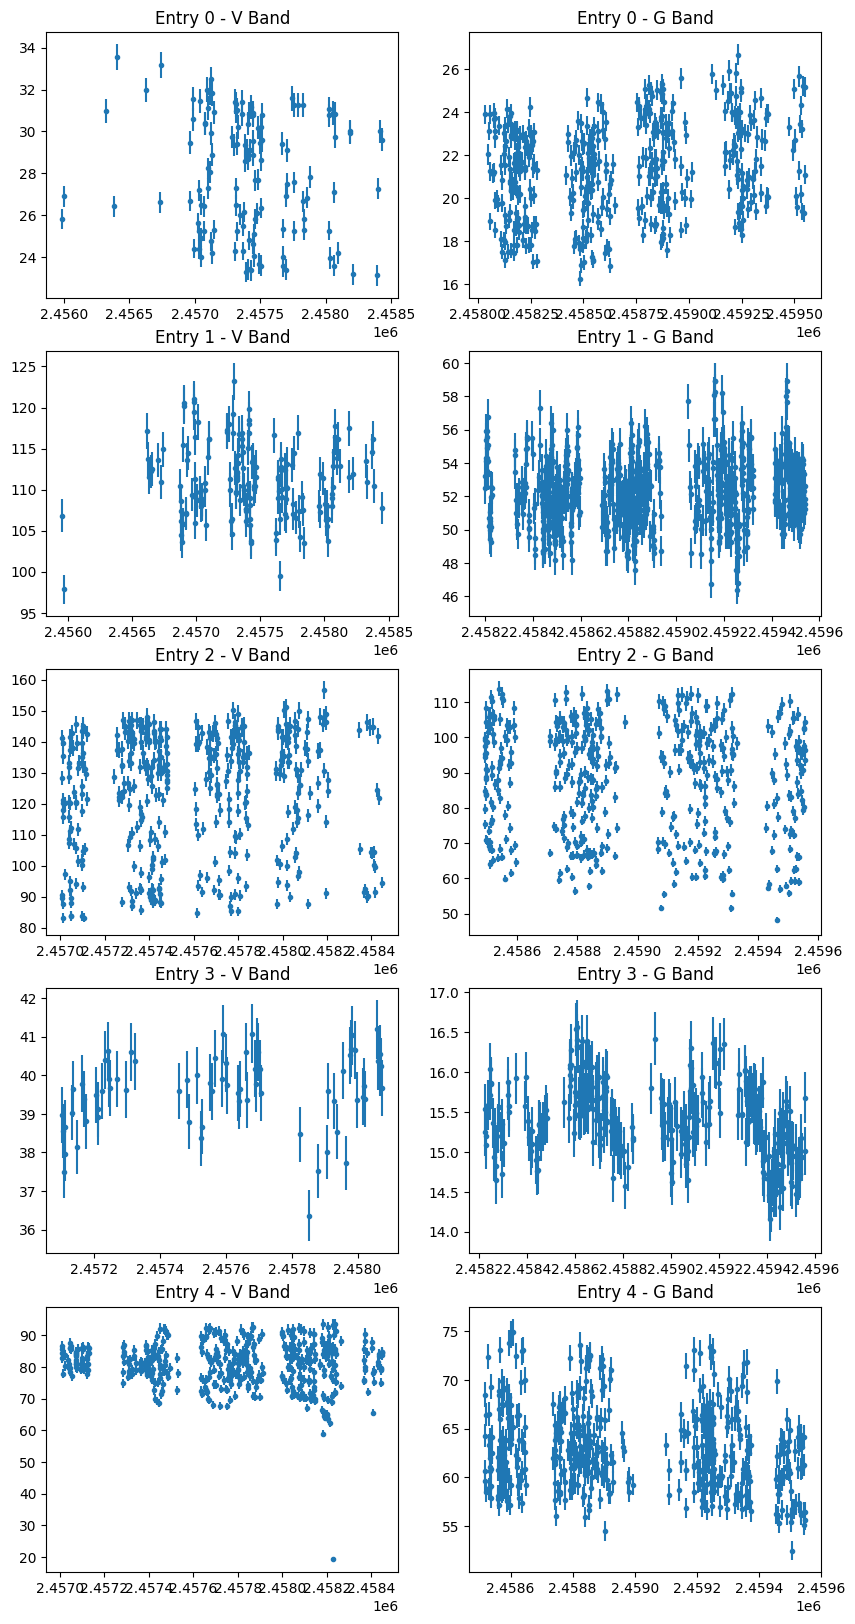

In [234]:
datapath = Path('../data/asaasn')
ds = ASASSNVarStarDataset(datapath, mode='train', verbose=True, only_periodic=True,
                          merge_type='inner', recalc_period=False, prime=True, use_bands=['v', 'g'],
                          only_sources_with_spectra=True, return_phased=False, fill_value=0)

fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(10, 20))

for i in range(5):
    v, g = ds[i]['lcs'][0]
    time_v, flux_v, flux_error_v = v[:, 0], v[:, 1], v[:, 2]
    time_g, flux_g, flux_error_g = g[:, 0], g[:, 1], g[:, 2]
  
    axs[i, 0].errorbar(time_v, flux_v, yerr=flux_error_v, fmt='.')
    axs[i, 0].set_title(f'Entry {i} - V Band')

    axs[i, 1].errorbar(time_g, flux_g, yerr=flux_error_g, fmt='.')
    axs[i, 1].set_title(f'Entry {i} - G Band')

plt.show()

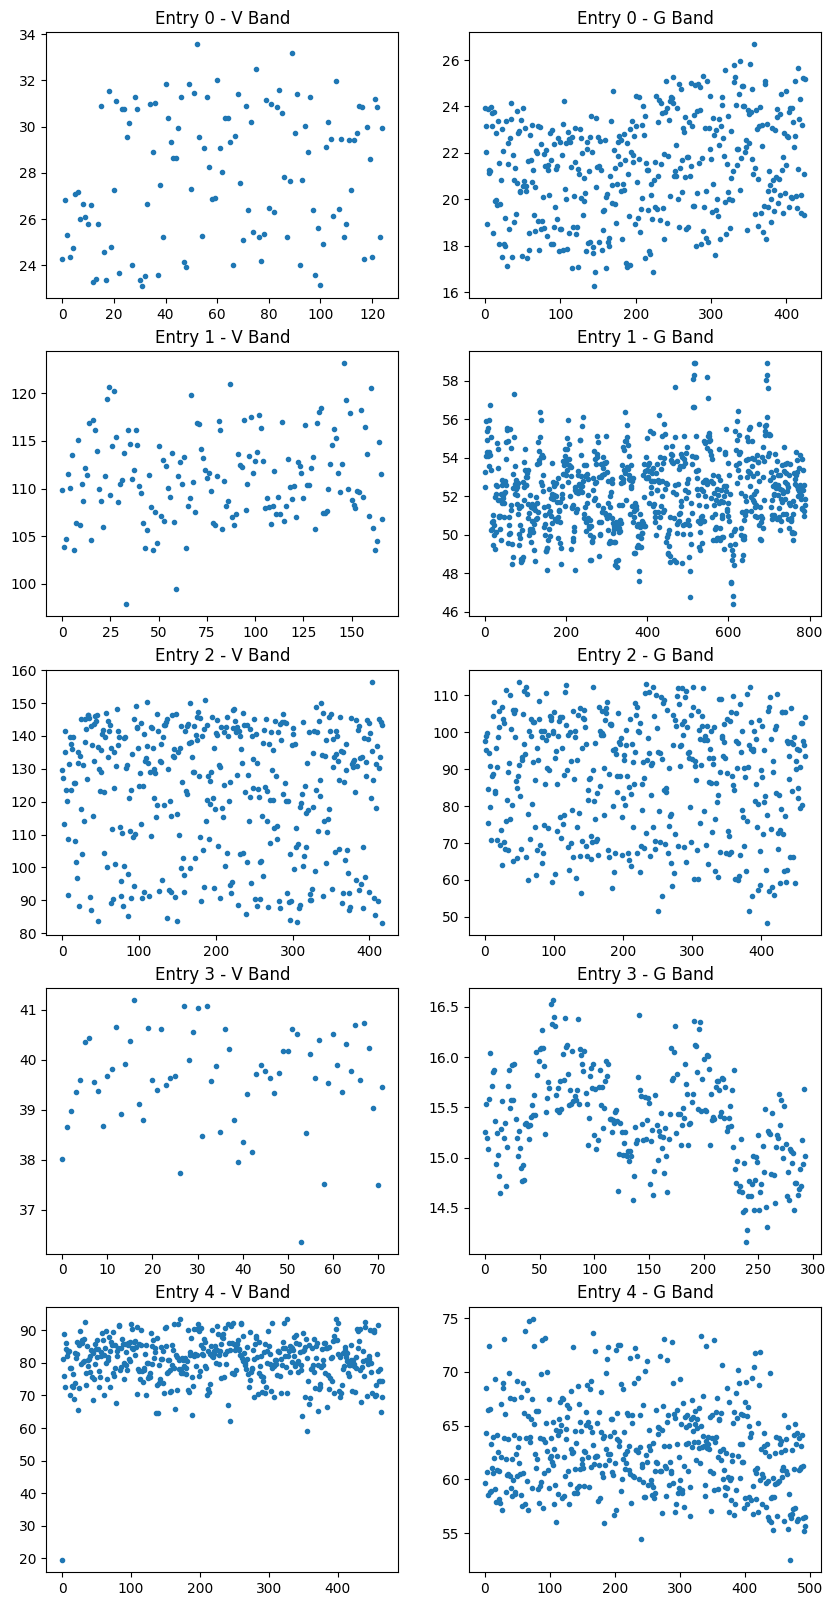

In [235]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(10, 20))

for i in range(5):
    v, g = ds[i]['lcs'][0]
    time_v, flux_v, flux_error_v = v[:, 0], v[:, 1], v[:, 2]
    time_g, flux_g, flux_error_g = g[:, 0], g[:, 1], g[:, 2]
  
    axs[i, 0].plot(flux_v, '.')
    axs[i, 0].set_title(f'Entry {i} - V Band')

    axs[i, 1].plot(flux_g, '.')
    axs[i, 1].set_title(f'Entry {i} - G Band')

plt.show()

In [236]:
ds[0]['lcs'][0][0][:, 0]

array([2457365.95661, 2457855.76899, 2457144.77172, 2456993.9448 ,
       2457128.80573, 2458065.07933, 2457036.95308, 2457344.98665,
       2456967.05934, 2457472.88101, 2455988.92169, 2456736.88445,
       2457391.04978, 2457405.93922, 2457457.80742, 2457444.93704,
       2457447.89434, 2457428.00823, 2456989.02387, 2457415.82801,
       2458403.08818, 2458026.11711, 2457488.8018 , 2457512.74941,
       2458028.10825, 2457442.82109, 2457480.80407, 2457451.87623,
       2457827.90594, 2457446.93766, 2457701.00733, 2458392.11233,
       2457676.07535, 2457825.87564, 2456324.945  , 2457135.77173,
       2457324.04747, 2457504.78209, 2457704.00951, 2457756.98589,
       2457131.79096, 2457077.7585 , 2457297.11313, 2457404.81628,
       2457507.77147, 2457125.82149, 2457762.05631, 2458092.03887,
       2458034.09366, 2457119.78214, 2457314.07309, 2457039.95524,
       2456406.77439, 2457514.7554 , 2457837.84283, 2457397.92067,
       2457786.81002, 2457099.90532, 2457697.09497, 2456000.93

In [237]:
no_spectra_data_keys = ['lcs', 'metadata', 'classes']
no_spectra_collate_fn = partial(collate_fn, data_keys=no_spectra_data_keys, fill_value=0)

train_dataloader = DataLoader(ds, batch_size=2, shuffle=False, collate_fn=no_spectra_collate_fn)

In [238]:
batch, masks = next(iter(train_dataloader))
lcs, metadata, classes = batch

In [239]:
lcs.shape

torch.Size([2, 2, 3, 790])

In [257]:
fluxes = lcs[:, :, 1, :]
times = lcs[:, :, 0, :]

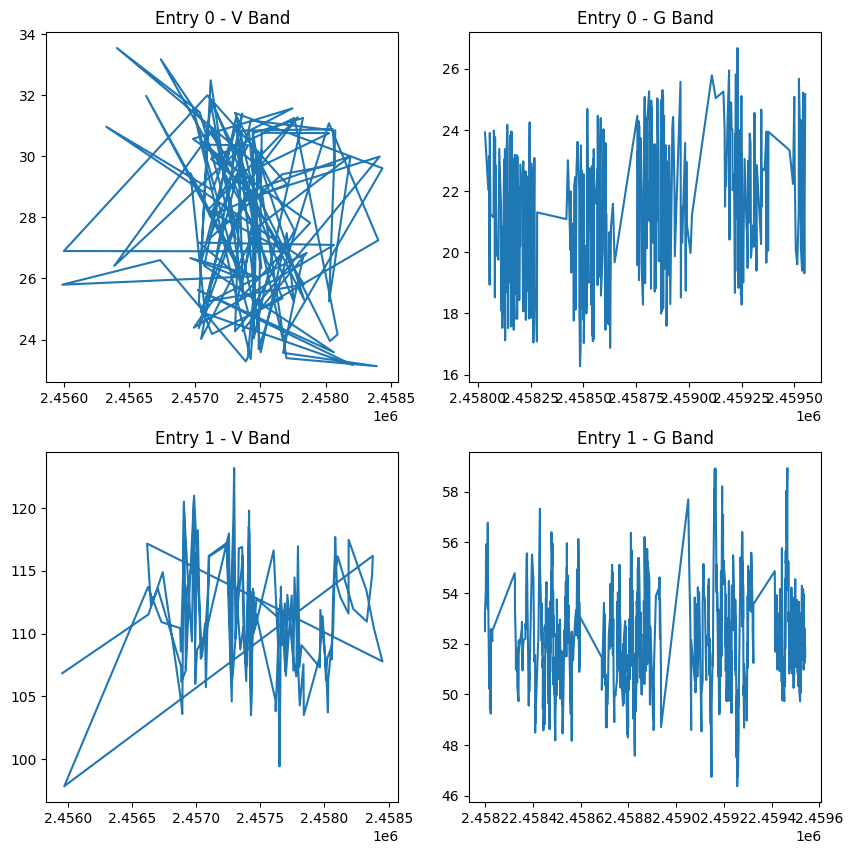

In [258]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

for i in range(B):
    flux_v, flux_g = fluxes[i, 0, :], fluxes[i, 1, :]
    time_v, time_g = times[i, 0, :], times[i, 1, :]

    flux_v = flux_v[flux_v != 0]
    flux_g = flux_g[flux_g != 0]
    time_v = time_v[time_v != 0]
    time_g = time_g[time_g != 0]
  
    axs[i, 0].plot(time_v, flux_v)
    axs[i, 0].set_title(f'Entry {i} - V Band')

    axs[i, 1].plot(time_g, flux_g)
    axs[i, 1].set_title(f'Entry {i} - G Band')
    
plt.show()

In [242]:
# Sorting along the last dimension and getting the indices
sorted_values, indices = torch.sort(lcs[:, :, 0, :], dim=-1)

# Using the indices to sort the other corresponding slices
sorted_lcs_1 = torch.gather(lcs[:, :, 1, :], -1, indices)
sorted_lcs_2 = torch.gather(lcs[:, :, 2, :], -1, indices)

# Reconstructing the sorted version of the original tensor
sorted_lcs = torch.stack([sorted_values, sorted_lcs_1, sorted_lcs_2], dim=2)

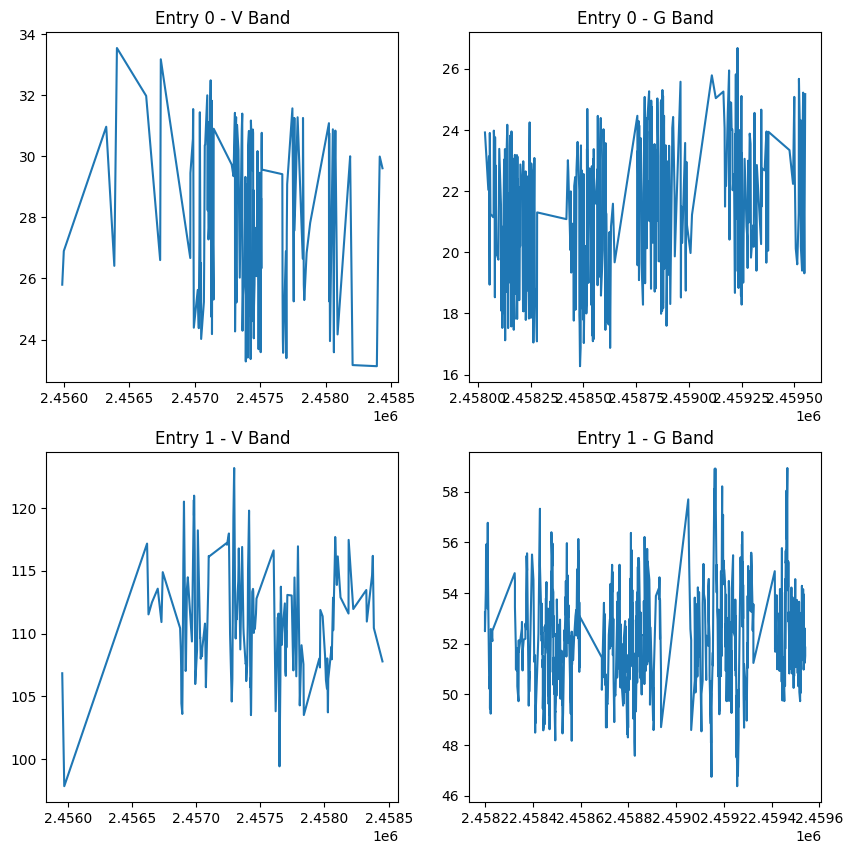

In [256]:
sorted_fluxes = sorted_lcs[:, :, 1, :]
sorted_times = sorted_lcs[:, :, 0, :]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

for i in range(B):
    sorted_flux_v, sorted_flux_g = sorted_fluxes[i, 0, :], sorted_fluxes[i, 1, :]
    sorted_time_v, sorted_time_g = sorted_times[i, 0, :], sorted_times[i, 1, :]

    sorted_flux_v = sorted_flux_v[sorted_flux_v != 0]
    sorted_flux_g = sorted_flux_g[sorted_flux_g != 0]
    sorted_time_v = sorted_time_v[sorted_time_v != 0]
    sorted_time_g = sorted_time_g[sorted_time_g != 0]
    
    axs[i, 0].plot(sorted_time_v, sorted_flux_v)
    axs[i, 0].set_title(f'Entry {i} - V Band')

    axs[i, 1].plot(sorted_time_g, sorted_flux_g)
    axs[i, 1].set_title(f'Entry {i} - G Band')

plt.show()

In [261]:
def FFT_for_Period(x, k=2):
    # [B, T, C]
    xf = torch.fft.rfft(x, dim=1)
    # find period by amplitudes
    frequency_list = abs(xf).mean(0).mean(-1)
    frequency_list[0] = 0
    _, top_list = torch.topk(frequency_list, k)
    top_list = top_list.detach().cpu().numpy()
    period = x.shape[1] // top_list
    return period, abs(xf).mean(-1)[:, top_list]

In [262]:
sorted_fluxes.shape

torch.Size([2, 2, 790])

In [263]:
sorted_fluxes = sorted_fluxes.transpose(1, 2)
sorted_fluxes.shape

torch.Size([2, 790, 2])

In [266]:
period_list, period_weight = FFT_for_Period(sorted_fluxes, k=5)

In [267]:
period_list, period_weight

(array([790, 395, 263, 197, 112]),
 tensor([[4329.9561, 1834.2812, 2007.8109, 1129.9525,  405.7343],
         [8671.6982, 6803.1963, 4316.6968, 1656.0281, 2024.5104]]))

In [197]:
period = period_list[0]

In [192]:
B, T, N = fluxes.shape

In [200]:
out = fluxes.reshape(B, T // period, period, N).permute(0, 3, 1, 2).contiguous()

In [201]:
out.shape

torch.Size([2, 2, 1, 790])